##### Loading Libraries

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install optuna
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import optuna
import xgboost as xgb

     |████████████████████████████████| 76.6 MB 96 kB/s 
     |████████████████████████████████| 80 kB 3.4 MB/s 
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 210 kB 49.7 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 53.7 MB/s 
     |████████████████████████████████| 112 kB 60.3 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5c3f008f08a750eb5099b267aaa9167d82fb874f51d6e517ea43c5999c7bc15d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
### Utility function 
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score
def acc(features,target,classifier):
    return {metrics.__name__ : metrics(target,classifier.predict(features)) for metrics in [accuracy_score,f1_score,precision_score,recall_score]}

def acc_th(features,target,classifier,th):
    return {metrics.__name__ : metrics(target,classifier.predict_proba(features)[:,1]>th) for metrics in [accuracy_score,f1_score,precision_score,recall_score]}

def acc_pd(features,target,classifier,th,metrics='metrics'):
    return pd.DataFrame(list(acc_th(features,target,classifier,th).items()), columns=['metric',metrics])

def Classification_Report(features,target,classifier):
    return classification_report(target,classifier.predict(features))

def Classification_Report_th(features,target,classifier,th):
    return classification_report(target,classifier.predict_proba(features)[:,1]>th)

def Confusion_Matrix(features,target,classifier):
    return confusion_matrix(target,classifier.predict(features))

def roc_auc(features,target,classifier):
    return roc_auc_score(target,classifier.predict_proba(features)[:,1])


import matplotlib.pyplot as plt
def roc_plot(feature,target,classifier):
    fpr, tpr, _ = sklearn.metrics.roc_curve(target,  classifier.predict_proba(feature)[:,1])
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



### Utility to get feature Importance
def FeatureImportance(features,fi):
    fi=pd.DataFrame(fi).T
    fi.columns=features.columns
    fi=fi.T
    fi.columns=['Importance']
    return fi.sort_values(by='Importance',ascending=False)


########## plotting feature importance
def feature_imp_plot(features,fi):
    df=FeatureImportance(features,fi)
    df=df.reset_index()
    df['cumulative_imp']=df['Importance'].cumsum() * 100
    plt.figure(figsize=(15,8))
    ax=sns.barplot(x='cumulative_imp',y='index',data=df)
    plt.show()
    print(df)

### Precision Recall curve
from sklearn.metrics import precision_recall_curve
def Precision_Recall_curve(feature,target,classifier):
    precision, recall, th = precision_recall_curve(target, classifier.predict_proba(feature)[:,1])
    plt.plot(th, precision[1:], label="Precision",linewidth=5) 
    plt.plot(th, recall[1:], label="Recall",linewidth=5) 
    plt.title('Precision and recall for different threshold values') 
    plt.xlabel('Threshold') 
    plt.ylabel('Precision/Recall') 
    plt.legend() 
    plt.show()

#### Decile report
def decile_report_binary(feature,target,classifier,q):
    Y=decile_input(feature,target,classifier)
    Y['y_0']=list(map(lambda x: 1 if x==0.0 else 0,Y['actual']))
    contacts=Y['actual'].count()
    reponders=1.0*Y['actual'].sum()
    deceivers=1.0*Y['y_0'].sum()
    resp_rate=reponders/contacts
    print('Response Rate:{}%'.format(resp_rate*100))
    Y.sort_values(by=['score'],ascending=False,inplace=True)
    Y['rank']=Y[['score']].rank(method='first',ascending=False)
    Y['decile']=pd.qcut(Y['rank'],q,labels=False)
    perf=pd.DataFrame()
    perf['freq']=Y.groupby(by='decile')['actual'].count()
    perf['act_mean']=Y.groupby(by='decile')['actual'].mean()
    perf['prob_mean']=Y.groupby(by='decile')['score'].mean()
    perf['prob_min']=Y.groupby(by='decile')['score'].min()
    perf['prob_max']=Y.groupby(by='decile')['score'].max()
    perf['num_1']=Y.groupby(by='decile')['actual'].sum()
    perf['num_0']=Y.groupby(by='decile')['y_0'].sum()
    perf=perf.reset_index()
    perf['decile']=perf.decile.map(lambda x:x+1)
    perf['cum_1']=perf['num_1'].rolling(window=len(perf),min_periods=1).sum()
    perf['cum_0']=perf['num_0'].rolling(window=len(perf),min_periods=1).sum()
    perf['per_cum_1']=perf['cum_1']/reponders*100
    perf['per_cum_0']=perf['cum_0']/deceivers*100
    perf['event_rate']=list(map(lambda x,y,z:y/(x*z)*100,perf['decile'],perf['cum_1'],perf['freq']))
    perf['cum_lift']=perf['event_rate']/(resp_rate*100)
    perf['capture_rate']=perf['num_1']/perf['num_1'].sum()
    print(perf)
    return perf

def decile_input(feature,target,classifier):
    Y=pd.DataFrame()
    Y['actual']=target
    Y.reset_index(inplace=True)
    Y.drop('index',axis=1,inplace=True)
    Y['score']=classifier.predict_proba(feature)[:,1]
    return Y







##### Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data (1).csv')
metadata=pd.read_csv('/content/drive/MyDrive/metadata.csv')

###### Checking the shape, Missing Values and Outliers

In [ ]:
## Checking File is loaded properly, Checking the shape of file 
df.shape

(99999, 27)

In [ ]:
## printing top 5 records to get intution about data
df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
0,False,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,1,0,22683,320,50,2528,0,39,100075,221,10,1,28,14,0
1,True,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,1,0,17037,320,50,1934,2,39,-1,16,10,2,22,19,1
2,False,1005,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,1,0,22155,320,50,2552,3,167,100202,23,10,3,23,18,0
3,False,1002,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,0,21591,320,50,2478,3,167,100074,23,10,2,22,19,0
4,True,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,1,0,15708,320,50,1722,0,35,-1,79,10,1,21,8,1


In [ ]:
## Checking data types
df.info()

### there are 9 object data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             99999 non-null  bool  
 1   C1                99999 non-null  int64 
 2   banner_pos        99999 non-null  int64 
 3   site_id           99999 non-null  object
 4   site_domain       99999 non-null  object
 5   site_category     99999 non-null  object
 6   app_id            99999 non-null  object
 7   app_domain        99999 non-null  object
 8   app_category      99999 non-null  object
 9   device_id         99999 non-null  object
 10  device_ip         99999 non-null  object
 11  device_model      99999 non-null  object
 12  device_type       99999 non-null  int64 
 13  device_conn_type  99999 non-null  int64 
 14  C14               99999 non-null  int64 
 15  C15               99999 non-null  int64 
 16  C16               99999 non-null  int64 
 17  C17         

In [ ]:
### Checking for Missing values in the data
df.isnull().any().any()

## data does not have missing values

df.describe().T

### Also Inituitively we can see the data is categorical in nature and the numerical data does not have outliers

,count,mean,std,min,25%,50%,75%,max
C1,99999.0,1004.967550,1.091916,1001.0,1005.0,1005.0,1005.0,1012.0
banner_pos,99999.0,0.289943,0.505707,0.0,0.0,0.0,1.0,7.0
device_type,99999.0,1.016390,0.531100,0.0,1.0,1.0,1.0,5.0
device_conn_type,99999.0,0.329453,0.854673,0.0,0.0,0.0,0.0,5.0
C14,99999.0,18857.231732,4944.919482,375.0,16920.0,20346.0,21893.0,24043.0
C15,99999.0,318.834548,21.510752,120.0,320.0,320.0,320.0,1024.0
C16,99999.0,60.278743,47.713436,20.0,50.0,50.0,50.0,1024.0
C17,99999.0,2114.613036,607.469442,112.0,1863.0,2323.0,2526.0,2757.0
C18,99999.0,1.439904,1.326824,0.0,0.0,2.0,3.0,3.0
C19,99999.0,227.234932,351.472366,33.0,35.0,39.0,171.0,1839.0


In [ ]:
### printing the metadata to get intution about data
metadata

### Looking at data and metadata we developed an intution that most of the features are categorical in nature 
### and thus needs to be treated before using in the model

,Variable,Description
0,click,0/1 for non-click/click
1,hour,format is YYMMDDHH
2,C1,anonymized categorical variable
3,banner_pos,position of the ad/banner on the page
4,site_id,unique id of the site on which the ad is shown
5,site_domain,unique domain of the site on which the ad is s...
6,site_category,category of the site on which the ad is shown
7,app_id,app id of the site on which the ad is shown
8,app_domain,app category of the site on which the ad is shown
9,app_category,category id of the site on which the ad is shown


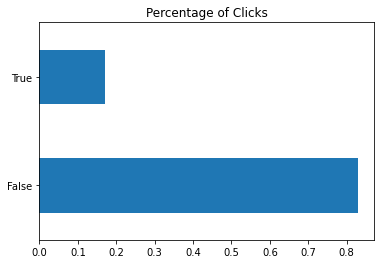

In [ ]:
### Checking for imbalance
import matplotlib.pyplot as plt
df['click'].value_counts(normalize=True).plot.barh()
plt.title('Percentage of Clicks')
plt.show()

### The Non clicks are 83% whereas clicks are 17%

Findings:
1. There are 83% Non clicks(click False) & 17% Clicks(clicks True)
2. There are no missing value in the data
3. There are various categorical features which needs to be treated
4. Categorical features are 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category','app_id', 'app_domain', 'app_category', 'device_id', 'device_ip','device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16','C17', 'C18', 'C19', 'C20', 'C21'
5. 'month', 'dayofweek', 'day', 'hour' can be considered as ordinal features

In [ ]:
## checking unique values in dataframe
n = df.nunique(axis=0)
n.sort_values(ascending=False)

device_ip           78013
device_id           16801
device_model         3145
C14                  1722
site_id              1485
app_id               1354
site_domain          1331
C17                   399
C20                   154
app_domain             96
C19                    64
C21                    60
hour                   24
app_category           21
site_category          19
day                    10
C16                     9
C15                     8
C1                      7
banner_pos              7
dayofweek               7
device_conn_type        4
C18                     4
device_type             4
click                   2
y                       2
month                   1
dtype: int64

In [ ]:
### Since month has only one value i.e. zero variance thus dropping month as it does not add any value
df=df.drop('month',axis=1)

#### Since the variance of 'device_ip' & 'device_id' is very high dropping them
#### Also with the metadata and understanding of data we got to know that these features will identify the device thus will create problems in generalisation
df =df.drop(['device_ip','device_id'],axis=1)

## Perform categorical variable treatment

There are Several Statistical ways to handle categorical features
Here we will try to use
1. One Hot Encoding
2. Target guided Encoding
One hot encoding will be used for features with low freq whereas Target guided Encoding will be used for features with high freq, we will use data intution to select type of encoding for a feature
But Before Encoding we will split the data to prevent Data Leakage & Effectively test the model/Endodings¶

In [ ]:
## Splitting into Target and features
y=df['y']
X=df.copy()
X=X.drop(['click','y'],axis=1)

In [ ]:
### train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(69999, 22) (30000, 22) (69999,) (30000,)


In [ ]:

## Using Both One Hot & Target Encoding 
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
Cols_OHE=['device_type','banner_pos','device_conn_type','C18']
Cols_TAR=['C16','C15','C1','device_model','C14','site_id','app_id',
          'site_domain','C17','C20','app_domain','C19','C21','app_category','site_category']
ce_OHE = ce.OneHotEncoder(cols=Cols_OHE)
ce_TAR=ce.TargetEncoder(cols=Cols_TAR)

## Encoding Train Data
X_train_enc= ce_OHE.fit_transform(X_train)
X_train_enc = ce_TAR.fit_transform(X_train_enc,y_train)

## Encoding Test Data
X_test_enc= ce_OHE.transform(X_test)
X_test_enc = ce_TAR.transform(X_test_enc)
print(X_train_enc.shape,X_test_enc.shape)

clf = RandomForestClassifier()
clf.fit(X_train_enc,y_train)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=clf)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=clf)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=clf)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=clf)))
#FeatureImportance(X_train_enc,fi=clf.feature_importances_)
### One Hot Encoding results in a bit overfitting because of curse of dimentionality
### Also variables that are one hot encoded shows low feature importance 

### Since the model is overfitted we change some parameters


(69999, 37) (30000, 37)
Training {'accuracy_score': 0.9908427263246617, 'f1_score': 0.9725822319175327, 'precision_score': 0.9892108239798137, 'recall_score': 0.9565034494363116}
Testing {'accuracy_score': 0.8109333333333333, 'f1_score': 0.22892876563349648, 'precision_score': 0.372236958443855, 'recall_score': 0.1652925009815469}
Classification report 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     58113
           1       0.99      0.96      0.97     11886

    accuracy                           0.99     69999
   macro avg       0.99      0.98      0.98     69999
weighted avg       0.99      0.99      0.99     69999

Confusion metrics 
[[57989   124]
 [  517 11369]]


In [ ]:
### Changing Random Forest to prevent Overfitting 
### Using Class Weights as to prevent class impbalance 
## Using Both One Hot & Target Encoding 
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
Cols_OHE=['device_type','banner_pos','device_conn_type','C18']
Cols_TAR=['C16','C15','C1','device_model','C14','site_id','app_id',
          'site_domain','C17','C20','app_domain','C19','C21','app_category','site_category']
ce_OHE = ce.OneHotEncoder(cols=Cols_OHE)
ce_TAR=ce.TargetEncoder(cols=Cols_TAR)

## Encoding Train Data
X_train_enc= ce_OHE.fit_transform(X_train)
X_train_enc = ce_TAR.fit_transform(X_train_enc,y_train)

## Encoding Test Data
X_test_enc= ce_OHE.transform(X_test)
X_test_enc = ce_TAR.transform(X_test_enc)
print(X_train_enc.shape,X_test_enc.shape)

clf = RandomForestClassifier(max_depth=5, random_state=0,class_weight='balanced')
clf.fit(X_train_enc,y_train)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=clf)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=clf)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=clf)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=clf)))
#FeatureImportance(X_train_enc,fi=clf.feature_importances_)
### One Hot Encoding results in a bit overfitting because of curse of dimentionality
### Also variables that are one hot encoded shows low feature importance 

### Since the model is overfitted we change some parameters


(69999, 37) (30000, 37)
Training {'accuracy_score': 0.6376376805382934, 'f1_score': 0.42195939016886586, 'precision_score': 0.28935771214252226, 'recall_score': 0.778899545683998}
Testing {'accuracy_score': 0.6195333333333334, 'f1_score': 0.392743136837625, 'precision_score': 0.2693767333236024, 'recall_score': 0.7245779348252847}
Classification report 
              precision    recall  f1-score   support

           0       0.93      0.61      0.74     58113
           1       0.29      0.78      0.42     11886

    accuracy                           0.64     69999
   macro avg       0.61      0.69      0.58     69999
weighted avg       0.82      0.64      0.68     69999

Confusion metrics 
[[35376 22737]
 [ 2628  9258]]


Training {'accuracy_score': 0.6349090701295733, 'f1_score': 0.4116672038307473, 'precision_score': 0.28337347870182555, 'recall_score': 0.7522295137136127}
Testing {'accuracy_score': 0.6249666666666667, 'f1_score': 0.3957896998012996, 'precision_score': 0.27241812670954385, 'recall_score': 0.7234000785237534}
Classification report 
              precision    recall  f1-score   support

           0       0.92      0.61      0.74     58113
           1       0.28      0.75      0.41     11886

    accuracy                           0.63     69999
   macro avg       0.60      0.68      0.57     69999
weighted avg       0.81      0.63      0.68     69999

Confusion metrics 
[[35502 22611]
 [ 2945  8941]]


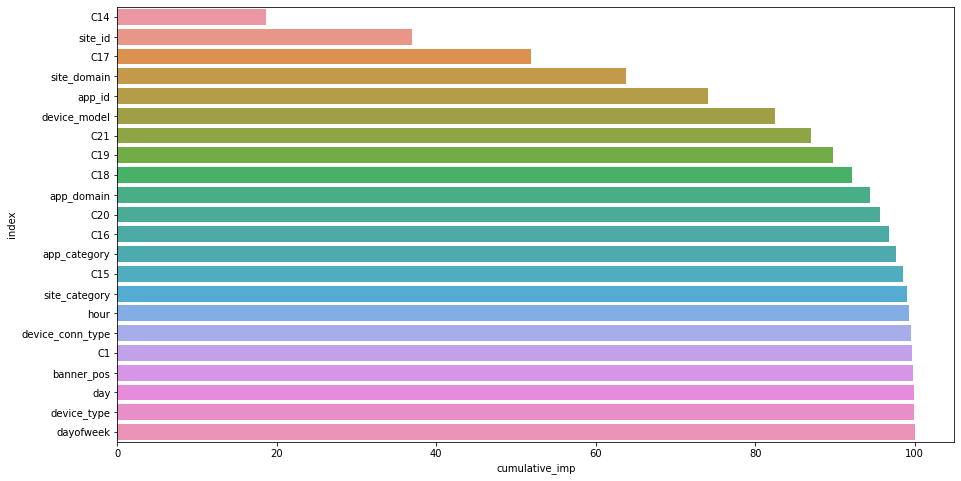

               index  Importance  cumulative_imp
0                C14    0.186348       18.634820
1            site_id    0.182658       36.900574
2                C17    0.149208       51.821368
3        site_domain    0.119463       63.767642
4             app_id    0.102662       74.033821
5       device_model    0.084973       82.531157
6                C21    0.045162       87.047377
7                C19    0.027440       89.791394
8                C18    0.024103       92.201679
9         app_domain    0.021519       94.353595
10               C20    0.013364       95.689970
11               C16    0.010641       96.754042
12      app_category    0.008980       97.652006
13               C15    0.008486       98.500632
14     site_category    0.005676       99.068268
15              hour    0.002587       99.326925
16  device_conn_type    0.001903       99.517248
17                C1    0.001372       99.654424
18        banner_pos    0.001248       99.779272
19               day

In [ ]:
###Thus changing the encoding to Weight of Evidence Encoder to prevent overfitting and to prevent curse of dimentionality
#### interpretability of model increases with WOE encoder compared to one hot encoding
cols_en=Cols_OHE+Cols_TAR
ce_enc=(ce.WOEEncoder(cols=cols_en))
X_train_enc=ce_enc.fit_transform(X_train,y_train)
X_test_enc=ce_enc.transform(X_test)
clf = RandomForestClassifier(max_depth=5, random_state=0,class_weight='balanced')
clf.fit(X_train_enc,y_train)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=clf)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=clf)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=clf)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=clf)))
feature_imp_plot(X_train_enc,clf.feature_importances_)
fi=FeatureImportance(X_train_enc,clf.feature_importances_)

1) From above example we will use WOE encoding because it has better validation evalutation metrics,
2) Is free from curse of dimentionality¶
3) Much better model explainability

In [ ]:
### selecting only the important features for Random forest
sel_features=list(FeatureImportance(X_train_enc,clf.feature_importances_).iloc[0:15].index)
X_train_enc=X_train_enc[sel_features]
X_test_enc=X_test_enc[sel_features]

## Model Selection : 
##### 3 classification methods you will use in the data set are
#### 1.  Random Forest: It is an ensemble method which uses bagging and tries to prevent overfitting also gives better accuracy 
####2.  Xgboost: It uses boosting technique and lear from the mistakes of the prior decision trees, this might get better evaluation metrics 
####3.  Linear Regression: It gives great explainability as it is parametric model and if business wants better inference and interpretability we can share the output from this model


## Model 0 Dummy Classifier

Training {'accuracy_score': 0.7175388219831712, 'f1_score': 0.16924750983510506, 'precision_score': 0.17065792790521805, 'recall_score': 0.16372202591283863}
Testing {'accuracy_score': 0.7157666666666667, 'f1_score': 0.17205565353713503, 'precision_score': 0.16828849456210646, 'recall_score': 0.17550058892815076}
training roc auc 0.5004844301802543
testing roc auc 0.50323702397812


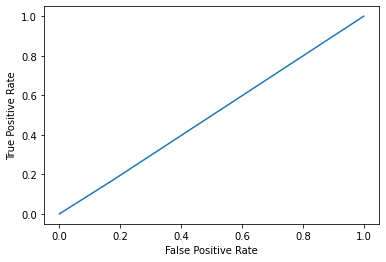

In [ ]:
from sklearn.dummy import DummyClassifier

dclf=DummyClassifier(strategy='stratified')

dclf.fit(X_train_enc,y_train)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=dclf)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=dclf)))
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=dclf)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=dclf)))
roc_plot(X_train_enc,y_train,classifier=dclf)


In [ ]:
### Training Decile Report
decile_report_binary(X_train_enc,y_train,dclf,q=10)

Response Rate:16.98024257489393%
   decile  freq  act_mean  prob_mean  prob_min  prob_max  num_1  num_0  \
0       1  7000  0.178000   1.000000       1.0       1.0   1246   5754   
1       2  7000  0.163000   0.703571       0.0       1.0   1141   5859   
2       3  7000  0.164000   0.000000       0.0       0.0   1148   5852   
3       4  7000  0.169857   0.000000       0.0       0.0   1189   5811   
4       5  7000  0.179000   0.000000       0.0       0.0   1253   5747   
5       6  6999  0.159594   0.000000       0.0       0.0   1117   5882   
6       7  7000  0.170714   0.000000       0.0       0.0   1195   5805   
7       8  7000  0.173857   0.000000       0.0       0.0   1217   5783   
8       9  7000  0.169286   0.000000       0.0       0.0   1185   5815   
9      10  7000  0.170714   0.000000       0.0       0.0   1195   5805   

     cum_1    cum_0   per_cum_1   per_cum_0  event_rate  cum_lift  \
0   1246.0   5754.0   10.482921    9.901399   17.800000  1.048277   
1   2387.0  11

,decile,freq,act_mean,prob_mean,prob_min,prob_max,num_1,num_0,cum_1,cum_0,per_cum_1,per_cum_0,event_rate,cum_lift,capture_rate
0,1,7000,0.178000,1.000000,1.0,1.0,1246,5754,1246.0,5754.0,10.482921,9.901399,17.800000,1.048277,0.104829
1,2,7000,0.163000,0.703571,0.0,1.0,1141,5859,2387.0,11613.0,20.082450,19.983480,17.050000,1.004108,0.095995
2,3,7000,0.164000,0.000000,0.0,0.0,1148,5852,3535.0,17465.0,29.740872,30.053516,16.833333,0.991348,0.096584
3,4,7000,0.169857,0.000000,0.0,0.0,1189,5811,4724.0,23276.0,39.744237,40.053000,16.871429,0.993592,0.100034
4,5,7000,0.179000,0.000000,0.0,0.0,1253,5747,5977.0,29023.0,50.286051,49.942354,17.077143,1.005707,0.105418
5,6,6999,0.159594,0.000000,0.0,0.0,1117,5882,7094.0,34905.0,59.683661,60.064013,16.892889,0.994856,0.093976
6,7,7000,0.170714,0.000000,0.0,0.0,1195,5805,8289.0,40710.0,69.737506,70.053172,16.916327,0.996236,0.100538
7,8,7000,0.173857,0.000000,0.0,0.0,1217,5783,9506.0,46493.0,79.976443,80.004474,16.975000,0.999691,0.102389
8,9,7000,0.169286,0.000000,0.0,0.0,1185,5815,10691.0,52308.0,89.946155,90.010841,16.969841,0.999387,0.099697
9,10,7000,0.170714,0.000000,0.0,0.0,1195,5805,11886.0,58113.0,100.000000,100.000000,16.980000,0.999986,0.100538


## Model 1 Random Forest

In [ ]:
### Reloading the entire data and transforming it for RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
X_train_enc=ce_enc.transform(X_train)
X_test_enc=ce_enc.transform(X_test)
X_train_enc=X_train_enc[sel_features]
X_test_enc=X_test_enc[sel_features]

In [ ]:
##### Using Optuna to find the best hyperparameters we have used recall as the evaluation criteria as we want capture as much clicks as possible also web as a channel is less expensive so recall should be as high as possible

In [ ]:
import optuna
import sklearn
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1000, 1500)
    max_depth = (trial.suggest_int('max_depth', 1, 9))
    min_samples_split = (trial.suggest_int('min_samples_split', 5, 100))
    min_samples_leaf  = (trial.suggest_int('min_samples_leaf', 5, 100))
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, random_state=0,class_weight='balanced')
    return sklearn.model_selection.cross_val_score(clf, X_train_enc, y_train, 
           n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-05-18 17:49:09,345] A new study created in memory with name: no-name-ed65afae-7cd8-4bf4-bc38-ebb691a69d19
[I 2022-05-18 17:49:42,740] Trial 0 finished with value: 0.6237660538007685 and parameters: {'n_estimators': 1413, 'max_depth': 3, 'min_samples_split': 61, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.6237660538007685.
[I 2022-05-18 17:50:26,663] Trial 1 finished with value: 0.6486378376833954 and parameters: {'n_estimators': 1095, 'max_depth': 8, 'min_samples_split': 66, 'min_samples_leaf': 73}. Best is trial 1 with value: 0.6486378376833954.
[I 2022-05-18 17:51:06,937] Trial 2 finished with value: 0.6316375948227831 and parameters: {'n_estimators': 1208, 'max_depth': 6, 'min_samples_split': 89, 'min_samples_leaf': 82}. Best is trial 1 with value: 0.6486378376833954.
[I 2022-05-18 17:51:37,130] Trial 3 finished with value: 0.6236946242089173 and parameters: {'n_estimators': 1329, 'max_depth': 3, 'min_samples_split': 75, 'min_samples_leaf': 22}. Best is trial 1 wi

In [ ]:
trial = study.best_trial
print('score: {}'.format(trial.value))

score: 0.657266532379034


In [ ]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'n_estimators': 1047, 'max_depth': 9, 'min_samples_split': 29, 'min_samples_leaf': 41}


Training {'accuracy_score': 0.6625523221760311, 'f1_score': 0.43524208009563653, 'precision_score': 0.30401817027956846, 'recall_score': 0.7657748611812216}
Testing {'accuracy_score': 0.6432333333333333, 'f1_score': 0.4049591371546116, 'precision_score': 0.28247886450011633, 'recall_score': 0.7149587750294464}
Classification report 
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     58113
           1       0.30      0.77      0.44     11886

    accuracy                           0.66     69999
   macro avg       0.62      0.70      0.60     69999
weighted avg       0.82      0.66      0.70     69999

Confusion metrics 
[[37276 20837]
 [ 2784  9102]]
training roc auc 0.7755548628692301
testing roc auc 0.7316180688623618


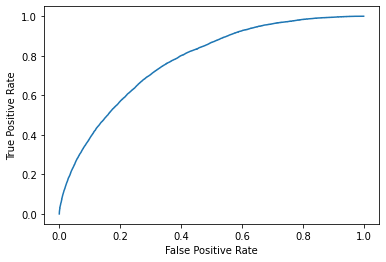

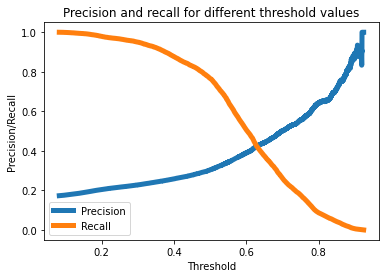

Confusion metrics 
[[15655  9251]
 [ 1452  3642]]


In [ ]:
### Training the final model after hyperparameter optimization and computing all the evaluation metrics
clf = RandomForestClassifier(max_depth=9 ,n_estimators=1047, random_state=0,min_samples_split= 29,min_samples_leaf= 41,class_weight='balanced')
clf.fit(X_train_enc,y_train)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=clf)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=clf)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=clf)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=clf)))
FeatureImportance(X_train_enc,fi=clf.feature_importances_)
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=clf)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=clf)))
roc_plot(X_train_enc,y_train,classifier=clf)
Precision_Recall_curve(X_train_enc,y_train,classifier=clf)
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_test_enc,y_test,classifier=clf)))

In [ ]:
print(Classification_Report_th(X_train_enc,y_train,classifier=clf,th=0.63))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     58113
           1       0.43      0.42      0.42     11886

    accuracy                           0.81     69999
   macro avg       0.65      0.65      0.65     69999
weighted avg       0.80      0.81      0.80     69999



In [ ]:
### Training Decile Report
rtf_decile_report=decile_report_binary(X_test_enc,y_test,clf,q=10)

Response Rate:16.98%
   decile  freq  act_mean  prob_mean  prob_min  prob_max  num_1  num_0  \
0       1  3000  0.414000   0.757865  0.683548  0.925515   1242   1758   
1       2  3000  0.289000   0.643002  0.611485  0.683532    867   2133   
2       3  3000  0.244333   0.583164  0.558987  0.611411    733   2267   
3       4  3000  0.214667   0.536670  0.513957  0.558948    644   2356   
4       5  3000  0.164667   0.486680  0.454428  0.513937    494   2506   
5       6  3000  0.130333   0.418042  0.383291  0.454394    391   2609   
6       7  3000  0.095000   0.345854  0.308234  0.383254    285   2715   
7       8  3000  0.076333   0.260413  0.212365  0.308222    229   2771   
8       9  3000  0.045667   0.178485  0.148001  0.212314    137   2863   
9      10  3000  0.024000   0.107169  0.016598  0.147992     72   2928   

    cum_1    cum_0   per_cum_1   per_cum_0  event_rate  cum_lift  capture_rate  
0  1242.0   1758.0   24.381625    7.058540   41.400000  2.438163      0.243816  
1 

In [ ]:
RTF_Training_accuracy=acc_pd(X_train_enc,y_train,classifier=clf,th=0.6,metrics='RTF_metrics')
RTF_Testing_accuracy=acc_pd(X_test_enc,y_test,classifier=clf,th=0.6,metrics='RTF_metrics')

In [ ]:
### Crossvalidation score shows the model is not overfitiing
sklearn.model_selection.cross_val_score(clf,X_train_enc,y_train,cv=3)

array([0.66120945, 0.65435221, 0.66103801])

## Model 2 Xgboost 

In [ ]:
### Reloading the entire data and transforming it for xgboost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
X_train_enc=ce_enc.transform(X_train)
X_test_enc=ce_enc.transform(X_test)

### Creating a validation data for early stopping and prevent data leakage not using test data 
X_train_enc, X_val_enc, y_train, y_val=train_test_split(X_train_enc,y_train, test_size=0.15, random_state=42, shuffle=True, stratify=y_train)

In [ ]:
### Class weights
from sklearn.utils import class_weight
class_weights=class_weight.compute_sample_weight(
    class_weight='balanced',y=y_train
)

Training {'accuracy_score': 0.7181633304761424, 'f1_score': 0.4086885997390599, 'precision_score': 0.3174298860648554, 'recall_score': 0.573592002375532}
Testing {'accuracy_score': 0.7062333333333334, 'f1_score': 0.37358731963892244, 'precision_score': 0.2928133704735376, 'recall_score': 0.5159010600706714}
Classification report 
              precision    recall  f1-score   support

           0       0.90      0.75      0.81     49396
           1       0.32      0.57      0.41     10103

    accuracy                           0.72     59499
   macro avg       0.61      0.66      0.61     59499
weighted avg       0.80      0.72      0.75     59499

Confusion metrics 
[[36935 12461]
 [ 4308  5795]]
training roc auc 0.7179671248237254
testing roc auc 0.6947524143468882


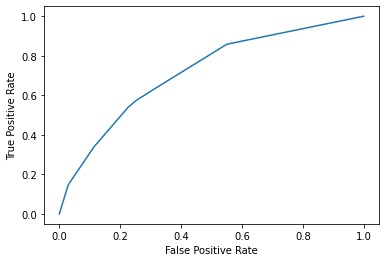

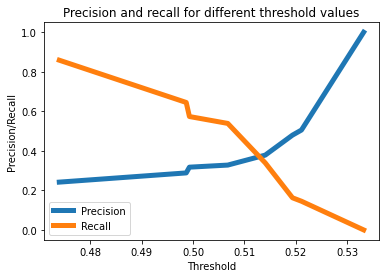

In [ ]:
### Simple xgb boost without hyperparameter tuning
xgb_model=xgb.XGBClassifier()
xgb_model.fit(X_train_enc,y_train,eval_set=[(X_val_enc,y_val)],sample_weight=class_weights,early_stopping_rounds=100,verbose=False)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=xgb_model)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=xgb_model)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=xgb_model)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=xgb_model)))
FeatureImportance(X_train_enc,fi=xgb_model.feature_importances_)
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=xgb_model)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=xgb_model)))
roc_plot(X_train_enc,y_train,classifier=xgb_model)
Precision_Recall_curve(X_train_enc,y_train,classifier=xgb_model)

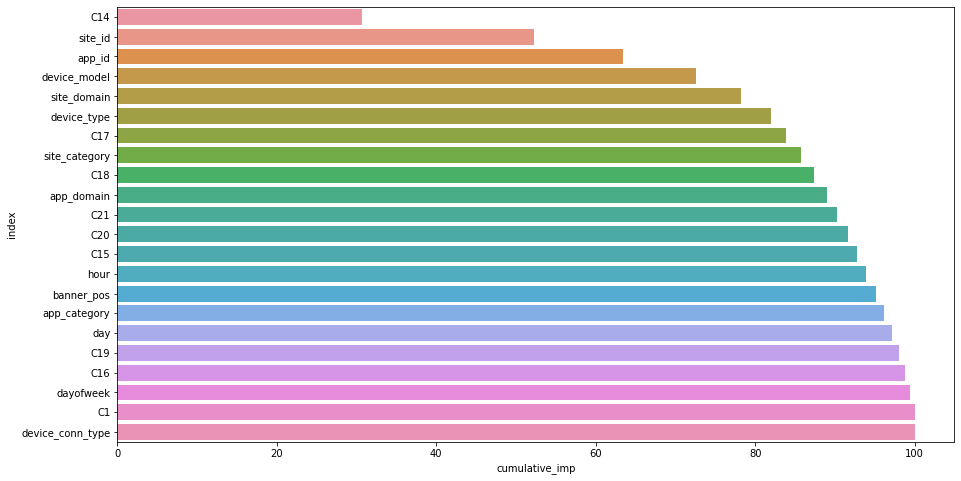

               index  Importance  cumulative_imp
0                C14    0.306730       30.672974
1            site_id    0.215610       52.233971
2             app_id    0.112365       63.470470
3       device_model    0.090916       72.562119
4        site_domain    0.056560       78.218094
5        device_type    0.037772       81.995300
6                C17    0.019205       83.915749
7      site_category    0.018278       85.743584
8                C18    0.016470       87.390556
9         app_domain    0.016022       88.992706
10               C21    0.013214       90.314117
11               C20    0.012866       91.600708
12               C15    0.011769       92.777580
13              hour    0.011736       93.951225
14        banner_pos    0.011698       95.120987
15      app_category    0.010528       96.173820
16               day    0.009378       97.111649
17               C19    0.009080       98.019669
18               C16    0.007264       98.746048
19         dayofweek

In [ ]:
## feature importance of xgboost classifier
feature_imp_plot(X_train_enc,xgb_model.feature_importances_)

In [ ]:
### Removing feature from xgboost model 
X_train_enc=X_train_enc.drop(['dayofweek','C1','device_conn_type'],axis=1)
X_test_enc=X_test_enc.drop(['dayofweek','C1','device_conn_type'],axis=1)
X_val_enc=X_val_enc.drop(['dayofweek','C1','device_conn_type'],axis=1)

In [ ]:
class_weights=class_weight.compute_sample_weight(
    class_weight='balanced',y=y_train
)

In [ ]:

def objective(trial):
    param = { 'lambda': trial.suggest_loguniform('lambda', 0.1, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
             'n_estimators' : trial.suggest_int('n_estimators', 300, 1000),
             'max_depth' : (trial.suggest_int('max_depth', 1, 7))
             }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_enc,y_train,eval_set=[(X_val_enc,y_val)],sample_weight=class_weights,early_stopping_rounds=10,verbose=False)
    return sklearn.model_selection.cross_val_score(model, X_train_enc, y_train, 
           n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-05-18 18:08:37,274] A new study created in memory with name: no-name-2e6d4303-33b6-4202-a08c-fc003b24406e
[I 2022-05-18 18:09:16,046] Trial 0 finished with value: 0.8381653473167616 and parameters: {'lambda': 1.973897710919484, 'alpha': 3.5298544846495132, 'learning_rate': 0.012, 'n_estimators': 828, 'max_depth': 4}. Best is trial 0 with value: 0.8381653473167616.
[I 2022-05-18 18:09:49,368] Trial 1 finished with value: 0.8380476982806434 and parameters: {'lambda': 1.896130128536074, 'alpha': 0.06706231611579387, 'learning_rate': 0.02, 'n_estimators': 720, 'max_depth': 4}. Best is trial 0 with value: 0.8381653473167616.
[I 2022-05-18 18:10:42,456] Trial 2 finished with value: 0.8374258390897326 and parameters: {'lambda': 1.2520691300249918, 'alpha': 0.011281306697841697, 'learning_rate': 0.02, 'n_estimators': 764, 'max_depth': 6}. Best is trial 0 with value: 0.8381653473167616.
[I 2022-05-18 18:11:35,575] Trial 3 finished with value: 0.8375771021361703 and parameters: {'lambda'

In [ ]:
trial = study.best_trial
print('score: {}'.format(trial.value))

score: 0.8384342593993176


In [ ]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'lambda': 0.11781716269683722, 'alpha': 1.2068301073958347, 'learning_rate': 0.018, 'n_estimators': 634, 'max_depth': 3}


In [ ]:
best_param={'lambda': 0.13015358387868833, 'alpha': 0.026660123369144632, 'learning_rate': 0.014, 'n_estimators': 772, 'max_depth': 3}


Training {'accuracy_score': 0.7181633304761424, 'f1_score': 0.4086885997390599, 'precision_score': 0.3174298860648554, 'recall_score': 0.573592002375532}
Testing {'accuracy_score': 0.7062333333333334, 'f1_score': 0.37358731963892244, 'precision_score': 0.2928133704735376, 'recall_score': 0.5159010600706714}
Classification report 
              precision    recall  f1-score   support

           0       0.90      0.75      0.81     49396
           1       0.32      0.57      0.41     10103

    accuracy                           0.72     59499
   macro avg       0.61      0.66      0.61     59499
weighted avg       0.80      0.72      0.75     59499

Confusion metrics 
[[36935 12461]
 [ 4308  5795]]
training roc auc 0.7179671248237254
testing roc auc 0.6947524143468882


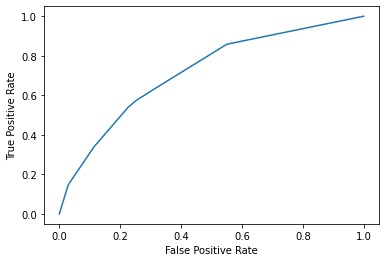

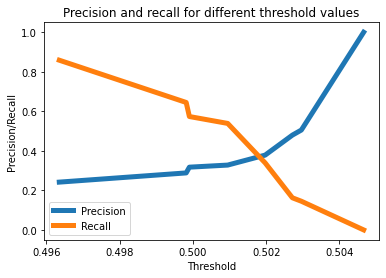

In [ ]:
xgb_model=xgb.XGBClassifier(**best_param)
xgb_model.fit(X_train_enc,y_train,eval_set=[(X_val_enc,y_val)],sample_weight=class_weights,early_stopping_rounds=100,verbose=False)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=xgb_model)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=xgb_model)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=xgb_model)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=xgb_model)))
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=xgb_model)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=xgb_model)))
roc_plot(X_train_enc,y_train,classifier=xgb_model)
Precision_Recall_curve(X_train_enc,y_train,classifier=xgb_model)

In [ ]:
xgb_model_decile_report=decile_report_binary(X_test_enc,y_test,xgb_model,q=10)

Response Rate:16.98%
   decile  freq  act_mean  prob_mean  prob_min  prob_max  num_1  num_0  \
0       1  3000  0.378333   0.503679  0.502715  0.504661   1135   1865   
1       2  3000  0.286000   0.502343  0.501972  0.502715    858   2142   
2       3  3000  0.214333   0.501690  0.499904  0.501972    643   2357   
3       4  3000  0.187000   0.499880  0.499817  0.499904    561   2439   
4       5  3000  0.181667   0.499817  0.499817  0.499817    545   2455   
5       6  3000  0.177333   0.499817  0.499817  0.499817    532   2468   
6       7  3000  0.074333   0.496509  0.496353  0.499817    223   2777   
7       8  3000  0.069333   0.496353  0.496353  0.496353    208   2792   
8       9  3000  0.059000   0.496353  0.496353  0.496353    177   2823   
9      10  3000  0.070667   0.496353  0.496353  0.496353    212   2788   

    cum_1    cum_0   per_cum_1   per_cum_0  event_rate  cum_lift  capture_rate  
0  1135.0   1865.0   22.281115    7.488155   37.833333  2.228112      0.222811  
1 

In [ ]:
XGB_Training_accuracy=acc_pd(X_train_enc,y_train,classifier=xgb_model,th=0.5,metrics='XGB_metrics')
XGB_Testing_accuracy=acc_pd(X_test_enc,y_test,classifier=xgb_model,th=0.5,metrics='XGB_metrics')

In [ ]:
### Crossvalidation score shows the model is not overfitiing
sklearn.model_selection.cross_val_score(xgb_model,X_train_enc,y_train,cv=3)

array([0.8382998 , 0.8382998 , 0.83910654])

## Model 3 Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
X_train_enc=ce_enc.transform(X_train)
X_test_enc=ce_enc.transform(X_test)
#X_train_enc=X_train_enc[sel_features]
#X_test_enc=X_test_enc[sel_features]
from sklearn.utils import class_weight
class_weights=class_weight.compute_sample_weight(
    class_weight='balanced',y=y_train
)

In [ ]:
from sklearn.linear_model import LogisticRegression
import optuna
import sklearn
def objective(trial):
    logreg_c= trial.suggest_float('logreg_c', 1e-10, 1e10, log=True)
    model =LogisticRegression(class_weight='balanced',C=logreg_c)
    return sklearn.model_selection.cross_val_score(model, X_train_enc, y_train, 
           n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-05-19 05:28:48,848] A new study created in memory with name: no-name-bacec97d-35d3-4a90-8034-e2fe9c70b5fa
[I 2022-05-19 05:28:50,422] Trial 0 finished with value: 0.7504250060715153 and parameters: {'logreg_c': 6.894075270037029e-09}. Best is trial 0 with value: 0.7504250060715153.
[I 2022-05-19 05:28:51,413] Trial 1 finished with value: 0.623023186045515 and parameters: {'logreg_c': 5.568241767822897e-06}. Best is trial 0 with value: 0.7504250060715153.
[I 2022-05-19 05:28:52,720] Trial 2 finished with value: 0.6564236631951885 and parameters: {'logreg_c': 892451127.869305}. Best is trial 0 with value: 0.7504250060715153.
[I 2022-05-19 05:28:53,556] Trial 3 finished with value: 0.626780382576894 and parameters: {'logreg_c': 9.908728463035928e-05}. Best is trial 0 with value: 0.7504250060715153.
[I 2022-05-19 05:28:54,004] Trial 4 finished with value: 0.6252660752296461 and parameters: {'logreg_c': 1.0359913351053107e-06}. Best is trial 0 with value: 0.7504250060715153.
[I 2022

Training {'accuracy_score': 0.16980242574893928, 'f1_score': 0.2903095805092508, 'precision_score': 0.16980242574893928, 'recall_score': 1.0}
Testing {'accuracy_score': 0.1698, 'f1_score': 0.2903060352196957, 'precision_score': 0.1698, 'recall_score': 1.0}
Classification report 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     58113
           1       0.17      1.00      0.29     11886

    accuracy                           0.17     69999
   macro avg       0.08      0.50      0.15     69999
weighted avg       0.03      0.17      0.05     69999

Confusion metrics 
[[    0 58113]
 [    0 11886]]
training roc auc 0.7324124544509083
testing roc auc 0.7125936946554696


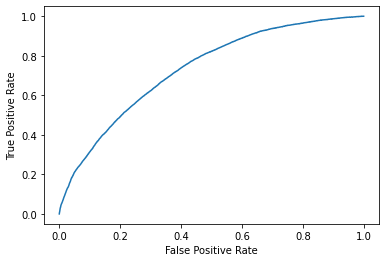

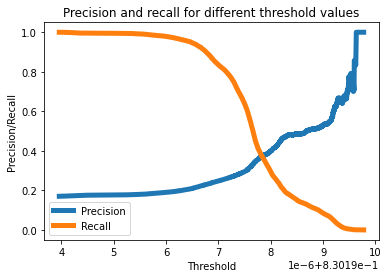

In [ ]:
model=LogisticRegression(class_weight='balanced',C=1.8476298080642516e-10)
model.fit(X_train_enc,y_train,sample_weight=class_weights)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=model)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=model)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=model)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=model)))
#FeatureImportance(X_train_enc,fi=model.feature_importances_)
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=model)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=model)))
roc_plot(X_train_enc,y_train,classifier=model)
Precision_Recall_curve(X_train_enc,y_train,classifier=model)

In [ ]:
print(Classification_Report_th(X_train_enc,y_train,classifier=model,th=0.8))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     58113
           1       0.17      1.00      0.29     11886

    accuracy                           0.17     69999
   macro avg       0.08      0.50      0.15     69999
weighted avg       0.03      0.17      0.05     69999



In [ ]:
print(Classification_Report_th(X_test_enc,y_test,classifier=model,th=0.84))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     24906
           1       0.00      0.00      0.00      5094

    accuracy                           0.83     30000
   macro avg       0.42      0.50      0.45     30000
weighted avg       0.69      0.83      0.75     30000



In [ ]:
from sklearn.feature_selection import RFE
selector = RFE(model)
selector = selector.fit(X_train_enc,y_train)
Logistic_features=list(X_train_enc.columns[selector.support_])

In [ ]:
X_train_enc=ce_enc.transform(X_train)
X_test_enc=ce_enc.transform(X_test)
X_train_enc=X_train_enc[Logistic_features]
X_test_enc=X_test_enc[Logistic_features]
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_enc.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_enc.values, i)
                          for i in range(len(X_train_enc.columns))]

In [ ]:
vif_data.sort_values(by='VIF',ascending=False)

,feature,VIF
6,C17,9.386529
0,site_id,7.181296
1,site_domain,6.922349
5,C14,6.679407
10,C21,4.892055
3,app_domain,3.557924
8,C19,3.300763
2,app_id,2.854512
7,C18,2.375697
9,C20,2.188377


In [ ]:
X_train_enc=X_train_enc.drop(['C17'],axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_enc.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_enc.values, i)
                          for i in range(len(X_train_enc.columns))]
vif_data.sort_values(by='VIF',ascending=False)

,feature,VIF
0,site_id,7.142954
1,site_domain,6.912488
9,C21,4.587639
3,app_domain,3.556130
7,C19,3.213293
5,C14,3.163563
2,app_id,2.837954
6,C18,2.355506
8,C20,2.182110
4,device_model,1.923412


In [ ]:
X_train_enc=X_train_enc.drop(['site_id'],axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_enc.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_enc.values, i)
                          for i in range(len(X_train_enc.columns))]
vif_data.sort_values(by='VIF',ascending=False)

,feature,VIF
8,C21,4.587607
2,app_domain,3.539526
6,C19,3.210055
4,C14,3.119965
1,app_id,2.833469
5,C18,2.354925
7,C20,2.176787
3,device_model,1.906204
0,site_domain,1.341714


In [ ]:
X_train_enc=X_train_enc[list(vif_data.feature)]
X_test_enc=X_test_enc[list(vif_data.feature)]
from sklearn.preprocessing import StandardScaler
std_scalar=StandardScaler()
X_train_enc=std_scalar.fit_transform(X_train_enc)
X_test_enc=std_scalar.fit_transform(X_test_enc)

In [ ]:

from sklearn.linear_model import LogisticRegression
import optuna
import sklearn
def objective(trial):
    logreg_c= trial.suggest_float('logreg_c', 1e-10, 1e10, log=True)
    model =LogisticRegression(class_weight='balanced',C=logreg_c)
    return sklearn.model_selection.cross_val_score(model, X_train_enc, y_train, 
           n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2022-05-19 05:29:16,290] A new study created in memory with name: no-name-a1f0fcb2-315f-4bb8-9a47-d1bf6edce4d5
[I 2022-05-19 05:29:16,557] Trial 0 finished with value: 0.6056943670623866 and parameters: {'logreg_c': 1.1338791323060535e-05}. Best is trial 0 with value: 0.6056943670623866.
[I 2022-05-19 05:29:16,863] Trial 1 finished with value: 0.6578808268689553 and parameters: {'logreg_c': 992969.9902239186}. Best is trial 1 with value: 0.6578808268689553.
[I 2022-05-19 05:29:17,158] Trial 2 finished with value: 0.6578808268689553 and parameters: {'logreg_c': 4653212015.84486}. Best is trial 1 with value: 0.6578808268689553.
[I 2022-05-19 05:29:17,403] Trial 3 finished with value: 0.6198088544122059 and parameters: {'logreg_c': 5.055596808668537e-05}. Best is trial 1 with value: 0.6578808268689553.
[I 2022-05-19 05:29:17,499] Trial 4 finished with value: 0.5179788282689753 and parameters: {'logreg_c': 1.499842487719445e-09}. Best is trial 1 with value: 0.6578808268689553.
[I 2022-0

Training {'accuracy_score': 0.31219017414534495, 'f1_score': 0.3264786525656091, 'precision_score': 0.19579516091143997, 'recall_score': 0.9817432273262662}
Testing {'accuracy_score': 0.3048666666666667, 'f1_score': 0.3214680809526908, 'precision_score': 0.19266770670826833, 'recall_score': 0.9697683549273656}
Classification report 
              precision    recall  f1-score   support

           0       0.98      0.18      0.30     58113
           1       0.20      0.98      0.33     11886

    accuracy                           0.31     69999
   macro avg       0.59      0.58      0.31     69999
weighted avg       0.85      0.31      0.30     69999

Confusion metrics 
[[10184 47929]
 [  217 11669]]
training roc auc 0.753710064500091
testing roc auc 0.7156792106045469


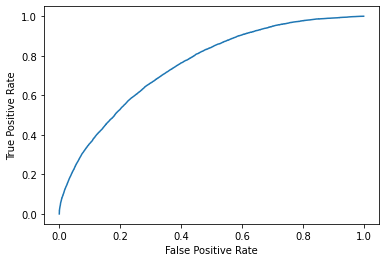

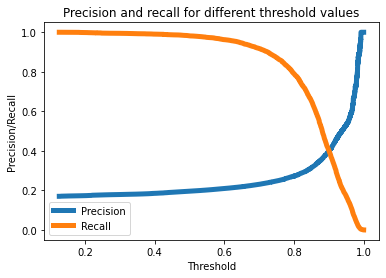

In [ ]:
model=LogisticRegression(class_weight='balanced',C= 0.063)
model.fit(X_train_enc,y_train,sample_weight=class_weights)
print('Training {}'.format(acc(X_train_enc,y_train,classifier=model)))
print('Testing {}'.format(acc(X_test_enc,y_test,classifier=model)))
print('Classification report \n{}'.format(Classification_Report(X_train_enc,y_train,classifier=model)))
print('Confusion metrics \n{}'.format(Confusion_Matrix(X_train_enc,y_train,classifier=model)))
#FeatureImportance(X_train_enc,fi=model.feature_importances_)
print('training roc auc {}'.format(roc_auc(X_train_enc,y_train,classifier=model)))
print('testing roc auc {}'.format(roc_auc(X_test_enc,y_test,classifier=model)))
roc_plot(X_train_enc,y_train,classifier=model)
Precision_Recall_curve(X_train_enc,y_train,classifier=model)

In [ ]:
print(Classification_Report_th(X_train_enc,y_train,classifier=model,th=0.86))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82     58113
           1       0.33      0.61      0.43     11886

    accuracy                           0.72     69999
   macro avg       0.62      0.68      0.62     69999
weighted avg       0.81      0.72      0.75     69999



In [ ]:
print(Classification_Report_th(X_test_enc,y_test,classifier=model,th=0.86))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80     24906
           1       0.30      0.56      0.39      5094

    accuracy                           0.70     30000
   macro avg       0.60      0.65      0.60     30000
weighted avg       0.79      0.70      0.73     30000



In [ ]:
logistic_decile_report=decile_report_binary(X_test_enc,y_test,model,q=10)

Response Rate:16.98%
   decile  freq  act_mean  prob_mean  prob_min  prob_max  num_1  num_0  \
0       1  3000  0.387333   0.951368  0.922345  0.996830   1162   1838   
1       2  3000  0.276667   0.905980  0.889975  0.922308    830   2170   
2       3  3000  0.246667   0.876920  0.864228  0.889975    740   2260   
3       4  3000  0.210667   0.850048  0.835057  0.864199    632   2368   
4       5  3000  0.173333   0.816825  0.796204  0.835052    520   2480   
5       6  3000  0.137000   0.773630  0.747754  0.796193    411   2589   
6       7  3000  0.104667   0.716419  0.682191  0.747754    314   2686   
7       8  3000  0.080667   0.634607  0.577847  0.682174    242   2758   
8       9  3000  0.049667   0.506336  0.425437  0.577651    149   2851   
9      10  3000  0.031333   0.281259  0.047770  0.425437     94   2906   

    cum_1    cum_0   per_cum_1   per_cum_0  event_rate  cum_lift  capture_rate  
0  1162.0   1838.0   22.811150    7.379748   38.733333  2.281115      0.228112  
1 

In [ ]:
confusion_matrix(y_test,model.predict_proba(X_test_enc)[:,1]>0.86)

array([[18263,  6643],
       [ 2242,  2852]])

In [ ]:
y_test.sum()

5094

In [ ]:
### Feature Importance Logistic Regression
fi=pd.DataFrame()
fi['columns']=list(vif_data.feature)
fi['coef']=list(model.coef_[0])
fi['abs_coef']=abs(fi['coef'])
fi.sort_values(by='abs_coef',ascending=False)

,columns,coef,abs_coef
1,app_id,0.595056,0.595056
0,site_domain,0.525547,0.525547
4,C14,0.499372,0.499372
3,device_model,0.483951,0.483951
2,app_domain,-0.430670,0.430670
8,C21,-0.115931,0.115931
5,C18,-0.076411,0.076411
6,C19,-0.016785,0.016785
7,C20,0.006222,0.006222


In [ ]:
### Crossvalidation score shows the model is not overfitiing
sklearn.model_selection.cross_val_score(model,X_train_enc,y_train,cv=3)

array([0.65542365, 0.65949514, 0.65893798])

## Compare which methods work best based on the evaluation metrics

In [ ]:
Logistic_Training_accuracy=acc_pd(X_train_enc,y_train,classifier=model,th=0.86,metrics='Logistic_metrics')
Logistic_Testing_accuracy=acc_pd(X_test_enc,y_test,classifier=model,th=0.86,metrics='Logistic_metrics')

In [ ]:
Logistic_Training_accuracy.merge(XGB_Training_accuracy,on='metric').merge(RTF_Training_accuracy,on='metric')

,metric,Logistic_metrics,XGB_metrics,RTF_metrics
0,accuracy_score,0.721767,0.718163,0.778254
1,f1_score,0.425758,0.408689,0.439720
2,precision_score,0.327735,0.317430,0.385068
3,recall_score,0.607437,0.573592,0.512452


In [ ]:
Logistic_Testing_accuracy.merge(XGB_Testing_accuracy,on='metric').merge(RTF_Testing_accuracy,on='metric')

,metric,Logistic_metrics,XGB_metrics,RTF_metrics
0,accuracy_score,0.703833,0.706233,0.758700
1,f1_score,0.390980,0.373587,0.386889
2,precision_score,0.300369,0.292813,0.340235
3,recall_score,0.559874,0.515901,0.448371


#### As per the results logistic regression model performs the best as it has better f1-score and better recall_score even the decile report and roc auc accuracy are better comparitively
#### Here the most important metrics for us is f1 score which balances both precision and recall 
#### as per the use case where and how the scores will be used we can change the threshold for better recall or precision 
#### But as per my understanding since we are predicting click through rate and the channel is web which is an inexpensive channel so we want to capture maximum thruth and we want high recall 
#### The decile report shows the model gives a lift of 2.2 times compared to random (dummy classifier) and the decile also holds i.e. with increase in decile cum_lift decreases and capture rate decreases


 # explain the risks associated with adopting the model to the business team

### Risk 1 : Drift in population vs the model training sample
#### All the inferences drawn above are based on the sample data if in production the actual population distribution is different from the training sample then this model will not perform well
#### Risk 2: The Model performs well but still there will be False positive i.e. model will predict customer will click the add but actually customer won't click the add and False negatives i.e. model will predict customer will not click the add but customer will actually click the add. So FP will lead to cost of channel as those customer are shown add but they actually dont click on add whereas FN will lead to opportunity cost i.e. model predicted customers will not click the add and were not shown the add but acctually they would have clicked it

#### Here in this case we should aim to decrease the FN as much as possible 
#### we have balanced the f1 score here so that both pression and recall are high but business can take judgement how deep in decile report they need to penetrate.




## Interpret the evaluation metric of choice 

#### the evaluation metrics of choice for us is recall score as it captures the amount of thruth model is able to capture i.e. it minimises the false negative and lowers the oportunity cost i.e. we will capture most of the customers who will click add with high recall score

## Explain the implications of errors made in the prediction by the model

 #### The Model performs well but still there will be False positive i.e. model will predict customer will click the add but actually customer won't click the add and False negatives i.e. model will predict customer will not click the add but customer will actually click the add. So FP will lead to cost of channel as those customer are shown add but they actually dont click on add whereas FN will lead to opportunity cost i.e. model predicted customers will not click the add and were not shown the add but acctually they would have clicked it
Here in this case we should aim to decrease the FN as much as possible
we have balanced the f1 score here so that both pression and recall are high but business can take judgement how deep in decile report they need to penetrate.

as per the confusion metrics recall score is 56% i.e. False negative are only 2242 whereas precison score is 30% i.e. False positive are 6643

Feature Engineering is helping to make model more robust it specially helped in increasing the f1 score and recall of the model. 
Feature Engineering i.e. feature selection is done for individual model whereas WOE encoding is done on global level